In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np

import warnings
warnings.filterwarnings("ignore")


import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

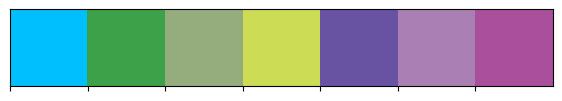

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

sns.palplot(sns.color_palette(a))



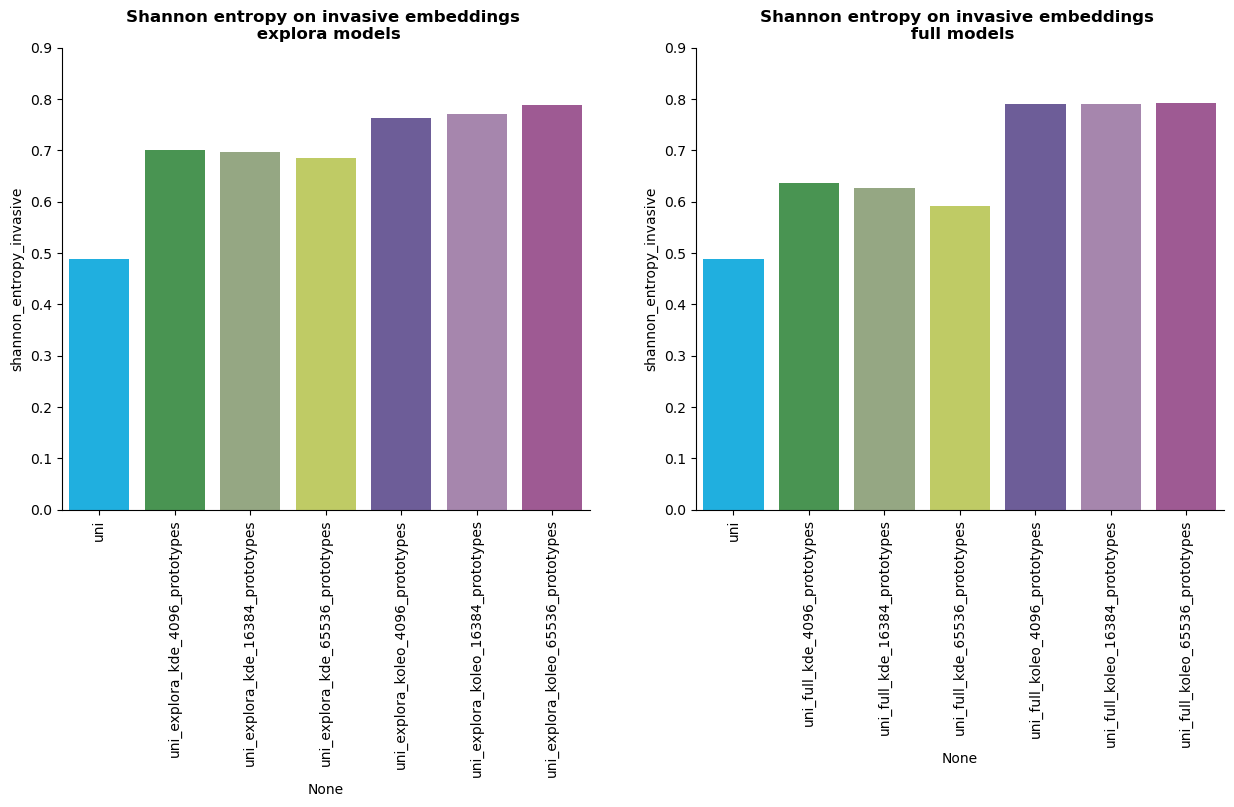

In [3]:
## Shannon entropy on invasive embeddings only
import json

plt.figure(figsize=(15, 6))
i = 0 

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):
  


  entropies = {}
  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:
          entropies[model] = json.load(f)['whole_matrix']['raw_cancer_patches']

  df_entropy_invasive = pd.DataFrame.from_dict(entropies, orient='index')
  df_entropy_invasive.columns = ["shannon_entropy_invasive"]

  plt.subplot(1, 2, i + 1)
  sns.barplot(x=df_entropy_invasive.index, y=df_entropy_invasive["shannon_entropy_invasive"], palette=a)
  sns.despine()
  plt.xticks(rotation=90)
  plt.title(f"Shannon entropy on invasive embeddings \n {model_type} models", weight="bold")
  plt.ylim(0, 0.9)

  plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_invasive_{model_type}_models.pdf"), bbox_inches='tight')
  i += 1

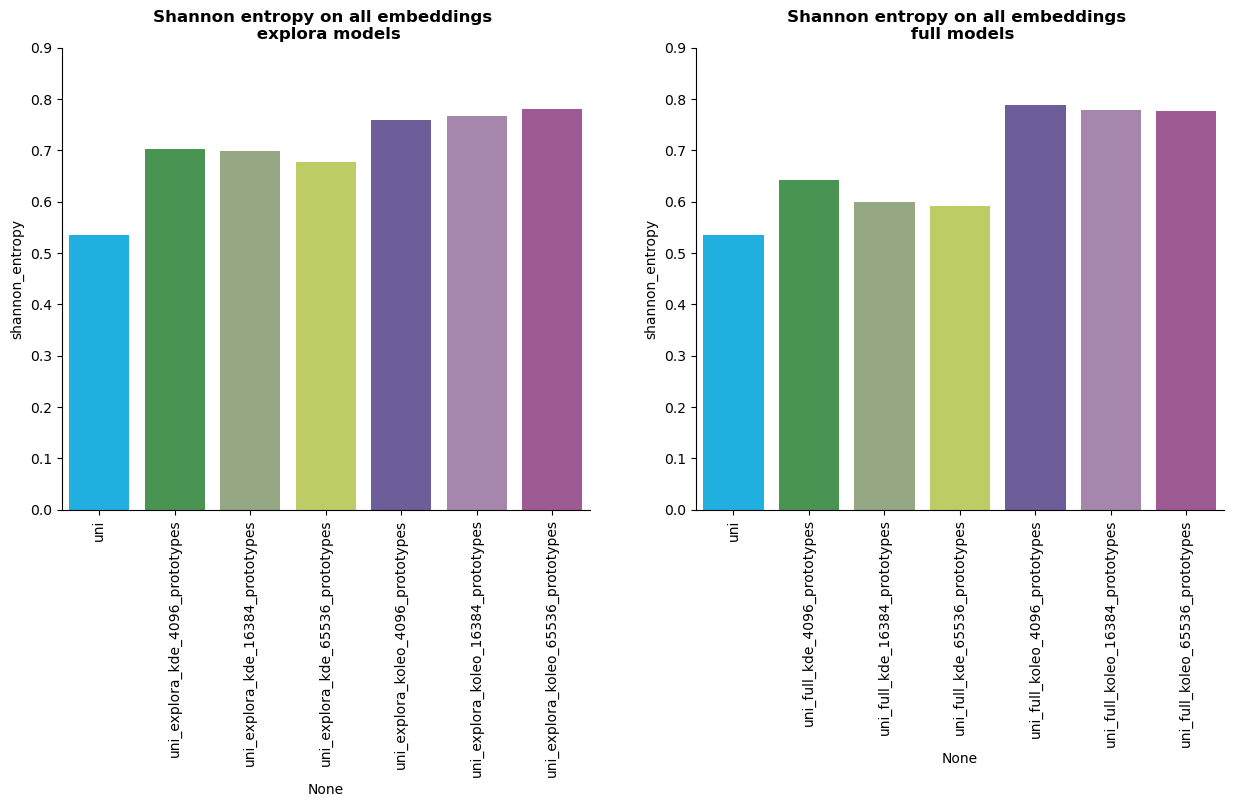

In [4]:
## Shannon entropy on whole embeddings 
import json

plt.figure(figsize=(15, 6))
i = 0 

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):

  entropies = {}
  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:

          entropies[model] = json.load(f)['whole_matrix']['raw_all_patches']

  df_entropy = pd.DataFrame.from_dict(entropies, orient='index')
  df_entropy.columns = ["shannon_entropy"]

  plt.subplot(1, 2, i + 1)
  sns.barplot(x=df_entropy.index, y=df_entropy["shannon_entropy"], palette=a)
  sns.despine()
  plt.xticks(rotation=90)
  plt.title(f"Shannon entropy on all embeddings \n {model_type} models", weight="bold")
  plt.ylim(0, 0.9)
  i += 1

plt.savefig(os.path.join(config['figures_folder'], "Figure3", "shannon_entropy_retrained_models_whole_patches.pdf"),
            bbox_inches='tight')

In [5]:
entropies = {}

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):

  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:

          entropies[model] = json.load(f)['whole_matrix']['raw_all_patches']

df_entropy = pd.DataFrame.from_dict(entropies, orient='index')

df_entropy.columns = ["shannon_entropy"]

In [6]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

df_entropy = df_entropy.loc[sort_retrained_models(df_entropy.index)]


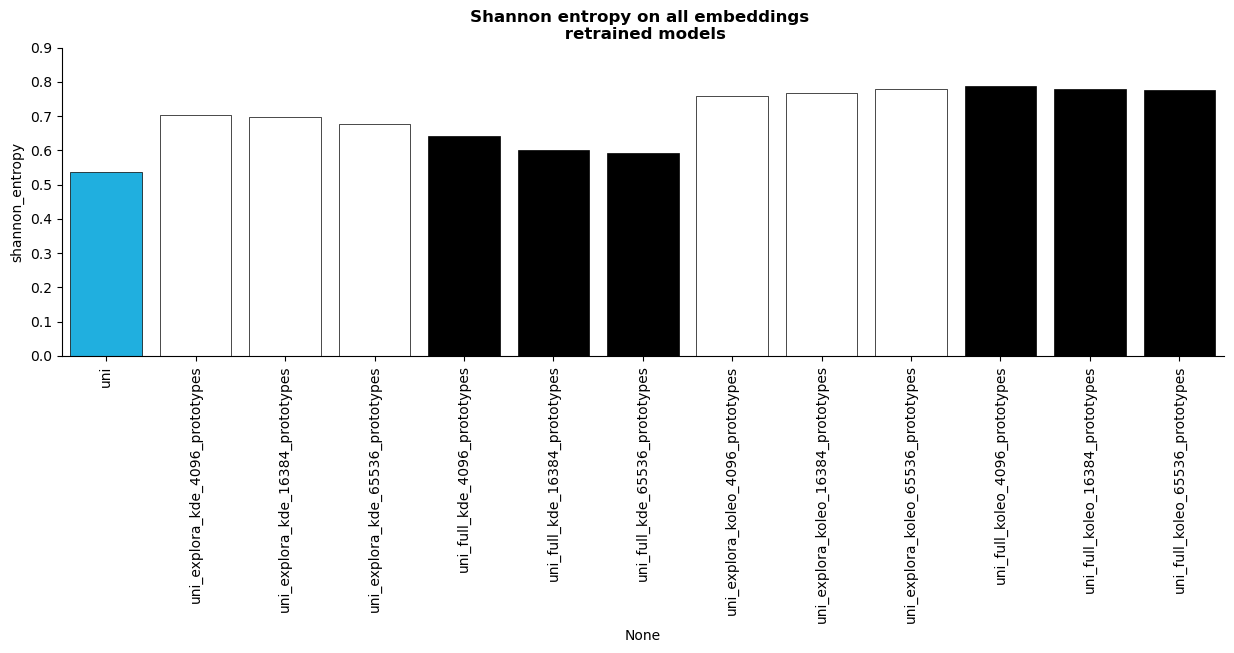

In [7]:
palette = []
for model in df_entropy.index:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(df_entropy, 
            x=df_entropy.index, 
            y="shannon_entropy", 
            palette=palette, 
            linewidth=0.5,
            edgecolor="black",
            )

plt.xticks(rotation=90)
sns.despine()

plt.title(f"Shannon entropy on all embeddings \n retrained models", weight="bold")
plt.ylim(0, 0.9)
plt.savefig(os.path.join(config['figures_folder'], "Figure3", "shannon_entropy_retrained_models.pdf"), 
            bbox_inches='tight')

## UMAP invasive cancer

In [15]:
import json

# This will give you the results for the full models
model_type=config['retrained_model_list2_type']

path = os.path.join(config['retrained_benchmark_folder2'], 'invasive_cancer_clustering_strategy_silhouette_and_batch_effect', config['invasive_cancer_clustering_algo'])

names = config['retrained_model_list2']

## Create Figure 3 folder

if not os.path.exists(os.path.join(config['figures_folder'], "Figure3")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure3"))

# UNCOMMENT THIS PART TO GET THE EXPLORA MODELS INSTEAD
names = config['retrained_model_list1']
model_type=config['retrained_model_list1_type']
path = os.path.join(config['retrained_benchmark_folder1'], 'invasive_cancer_clustering', config['invasive_cancer_clustering_algo'])



In [16]:
df_all_clusters = []

for min_dist in [0.001, 0.1]:
    for i, name in enumerate(names):
        dfs_clusters = []
        for k in [4, 5, 6, 7, 8, 9]:
        # for k in [5]:
            if os.path.exists(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json"):
                # print(f"Trying to read {path}/{name}/scores_umap_across_parameters_{k}_clusters.json")
                
                with open(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json", 'r') as f:
                    model_clusters = json.load(f)
                    
                    df_model_clusters = pd.DataFrame(model_clusters[str(min_dist)]).T
                    df_model_clusters = df_model_clusters.reset_index().rename(columns={"index": "n_neighbors"})
                    df_model_clusters["n_clusters"] = k
                    df_model_clusters["min_dist"] = min_dist
                    dfs_clusters.append(df_model_clusters)
            else:
                print(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json does not exist")
                
        dfs_clusters = pd.concat(dfs_clusters)  
        dfs_clusters["name"] = name      
        df_all_clusters.append(dfs_clusters)

In [17]:
df_all = pd.concat(df_all_clusters)

df_all['euclidian_dist_to_optimal'] = df_all.apply(lambda row: np.sqrt((row['silhouette_score'] - 1)**2 + (row['ARI_patient'] - 0)**2), axis=1)


df_all["euclidian_dist_to_optimal"] = pd.to_numeric(df_all["euclidian_dist_to_optimal"], errors='coerce')

# Drop rows where silhouette_score could not be converted to numeric
df_all = df_all.dropna(subset=["euclidian_dist_to_optimal"]).reset_index(drop=True)

# Group by 'name' and 'n_clusters' and get the index of the maximum 'silhouette_score'
idx = df_all.groupby(["name", "n_clusters"])["euclidian_dist_to_optimal"].idxmin()



best_scores = df_all.loc[idx]

best_scores_ordered = best_scores.set_index("name").loc[names].reset_index()

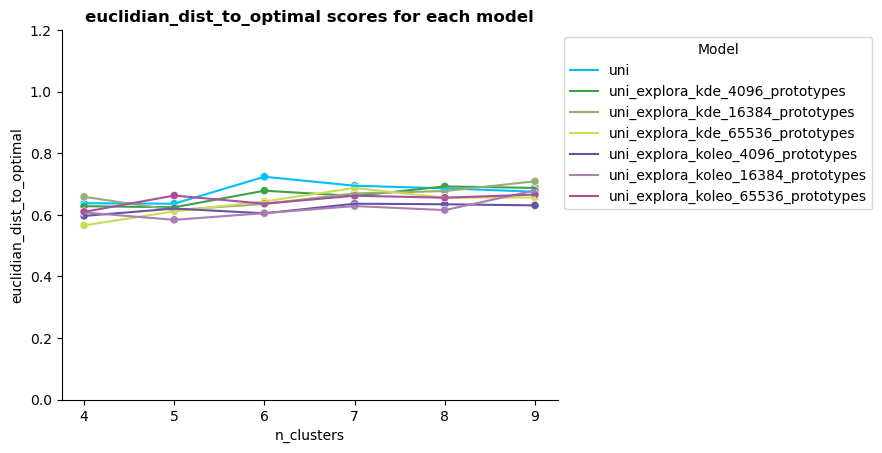

In [18]:



sns.lineplot(data=best_scores_ordered, x="n_clusters", y="euclidian_dist_to_optimal", hue="name", palette=a)
sns.scatterplot(data=best_scores_ordered, x="n_clusters", y="euclidian_dist_to_optimal", hue="name", palette=a, legend=False)
sns.despine()
plt.title("euclidian_dist_to_optimal scores for each model", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0,1.2)
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_best_euclidian_dist_to_optimal_{model_type}_models.pdf"), bbox_inches='tight')

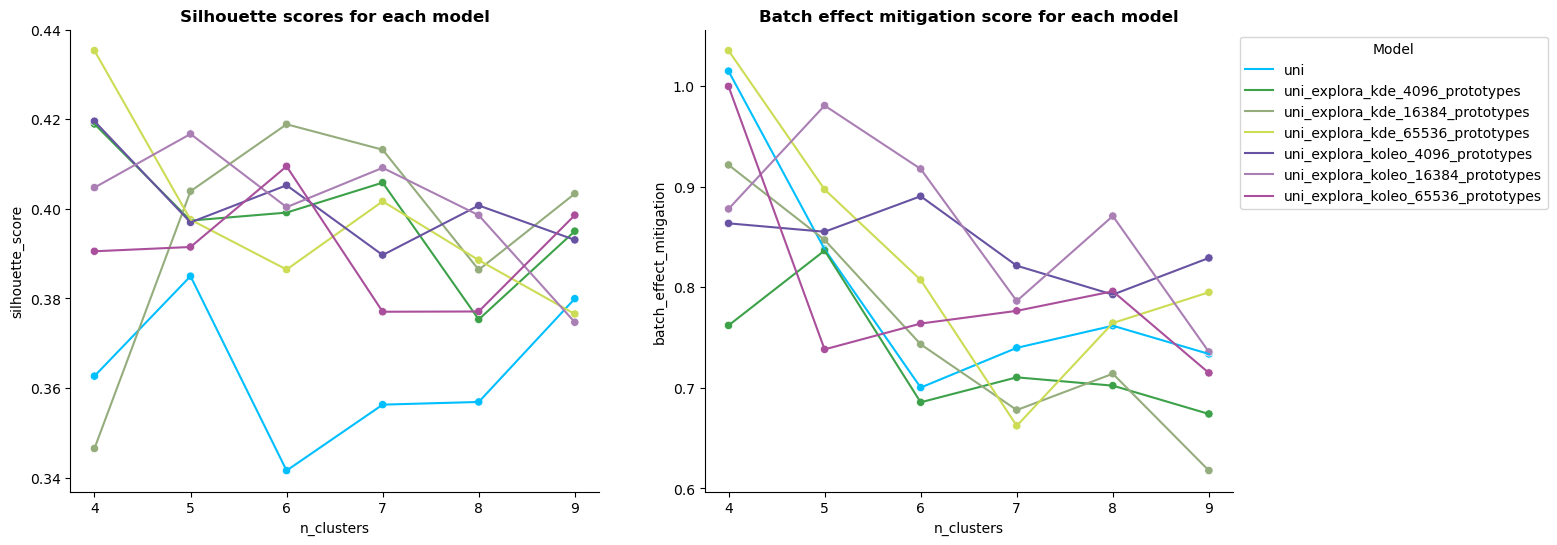

In [19]:

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=best_scores_ordered, x="n_clusters", y="silhouette_score", hue="name", palette=a)
sns.scatterplot(data=best_scores_ordered, x="n_clusters", y="silhouette_score", hue="name", palette=a, legend=False)
sns.despine()
plt.title("Silhouette scores for each model", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.legend().remove()
plt.subplot(1, 2, 2)
best_scores_ordered["batch_effect_mitigation"] = 1 - best_scores_ordered["ARI_patient"]
sns.lineplot(data=best_scores_ordered, x="n_clusters", y="batch_effect_mitigation", hue="name", palette=a)
sns.scatterplot(data=best_scores_ordered, x="n_clusters", y="batch_effect_mitigation", hue="name", palette=a, legend=False)
sns.despine()
plt.title("Batch effect mitigation score for each model", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))


In [20]:
opti_clusters = best_scores_ordered.loc[best_scores_ordered.groupby("name")["euclidian_dist_to_optimal"].idxmin()].set_index("name")
opti_clusters.loc["uni", "n_clusters"]
opti_clusters

,n_neighbors,data,labels,cluster_number,silhouette_score,inertia,davies_bouldin_score,calinski_harabasz_score,ARI_patient,n_clusters,min_dist,euclidian_dist_to_optimal,batch_effect_mitigation
name,,,,,,,,,,,,,
uni,100,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",5,0.384981,109084.066906,0.851323,40155.222528,0.16221,5,0.001,0.636050,0.83779
uni_explora_kde_16384_prototypes,10,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...",5,0.403939,389728.233482,0.765332,45698.092329,0.152944,5,0.100,0.615370,0.847056
uni_explora_kde_4096_prototypes,300,umap,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, ...",5,0.397382,118980.100835,0.758625,45277.446304,0.163532,5,0.001,0.624412,0.836468
uni_explora_kde_65536_prototypes,350,umap,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",4,0.435319,136958.631246,0.678091,46401.320624,-0.035385,4,0.001,0.565789,1.035385
uni_explora_koleo_16384_prototypes,300,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...",5,0.416716,97221.825293,0.729674,46246.396084,0.019303,5,0.001,0.583603,0.980697
uni_explora_koleo_4096_prototypes,300,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.419562,139228.819697,0.731658,37742.4534,0.136477,4,0.001,0.596267,0.863523
uni_explora_koleo_65536_prototypes,150,umap,"[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",4,0.390535,154296.580638,0.776103,35194.71483,0.000208,4,0.001,0.609465,0.999792


In [21]:

opti_clusters.to_csv(os.path.join(path, "optimal_clusters.csv"))